# Bibliotecas necessárias

In [ ]:
!pip install nltk scikit-learn spacy

# Imports necessários

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import StackingClassifier
import numpy as np
import spacy

!python -m spacy download en_core_web_lg

nlp = spacy.load("en_core_web_lg")

# Funções para tratamento e normalização dos dados textuais

In [ ]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

EMBEDDING_DIM = 300

def pre_processing(texts):
    #Remoção de espaços extras e normalização dos dados
    texts = texts.apply(lambda text: text.strip().lower())

    #Remoção de pontuação
    texts = texts.apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))

    #Tokenização por palavras e remoção de stopwords
    en_stopwords = set(stopwords.words('english'))
    texts = texts.apply(lambda text: [token for token in text.split() if token not in en_stopwords])

    #Stemmização
    stemmer = PorterStemmer()
    texts = texts.apply(lambda txt_tokens: [stemmer.stem(token) for token in txt_tokens])
    return texts

def vectorize(texts):
    texts = texts.apply(lambda txt_tokens: ' '.join(txt_tokens))
    vectorizer = CountVectorizer()
    return texts, vectorizer, vectorizer.fit_transform(texts)

def create_words_vectors(texts):
    words_vectors = {}
    for text in texts:
        doc = nlp(text)
        for token in doc:
            words_vectors[token.text] = token.vector
    return words_vectors

def create_words_embedding(texts):
    embedding = []
    zeros_arr = np.zeros(EMBEDDING_DIM)
    texts, vectorizer, vectors = vectorize(texts)
    words_vectors = create_words_vectors(texts)
    for word, _ in sorted(vectorizer.vocabulary_.items(), key=lambda kv: (kv[1], kv[0])):
        if word in words_vectors:
            word_arr = np.array(words_vectors[word])
            embedding.append(word_arr)
        else:
            embedding.append(zeros_arr)
    return vectors.dot(np.array(embedding))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Funções para estimação de hiperparâmetros do modelos

In [ ]:
RANDOM_STATE = 42

def plot_line_graph(**args):
    plt.title(args['title'])
    plt.xlabel(args['x_label'])
    plt.ylabel(args['y_label'])
    plt.xticks(ticks=range(len(args['hiper_param_list'])), labels=np.array(args['hiper_param_list']))
    plt.plot(args['accuracy_train_array'])
    plt.plot(args['accuracy_test_array'])
    plt.legend(args['legends'])
    plt.show()

def plot_train_validation_graph(model_name, metrics, **model_hyper_params):
    i = 0
    for hyper_param_name, hyper_param_list in model_hyper_params.items():
        train_hyper_param_accuracy_list, test_hyper_param_accuracy_list = metrics[i]
        params = {
            'title': f'Train x Validation - {model_name}', 'x_label': hyper_param_name, 'y_label': 'accuracy',
            'hiper_param_list': hyper_param_list, 'accuracy_train_array': train_hyper_param_accuracy_list,
            'accuracy_test_array': test_hyper_param_accuracy_list, 'legends': ['Train', 'Validation']
        }
        plot_line_graph(**params)
        i += 1

def get_model_accuracy(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    #Predição no conjunto de treino
    y_train_pred = model.predict(X_train)
    #Predição no conjunto de teste
    y_test_pred = model.predict(X_test)
    #Accuracy
    return accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

def get_metrics(models, X_train, y_train, X_test, y_test):
    hyper_param_accuracy_train = []
    hyper_param_accuracy_test = []

    for model in models:
        accuracy_train, accuracy_test = get_model_accuracy(model, X_train, y_train, X_test, y_test)
        hyper_param_accuracy_train.append(accuracy_train)
        hyper_param_accuracy_test.append(accuracy_test)

    return (hyper_param_accuracy_train, hyper_param_accuracy_test)

def get_model_metrics(model, X_train, y_train, X_test, y_test, template, **hyper_params_list):
    i = 0
    models_list = [[] for _ in range(len(hyper_params_list))]
    for hyper_param, hiper_param_list in hyper_params_list.items():
        for value in hiper_param_list:
            template[f'{hyper_param}'] = value
            models_list[i].append(model(**template))
        i += 1
    return [get_metrics(models, X_train, y_train, X_test, y_test) for models in models_list]


# Normalização dos dados e separação em treino e teste para os modelos

- Leitura, tratamento dos dados e separação em treino e teste

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('./datasets/train.csv')
texts = data['text']
texts = pre_processing(texts)
X, y = create_words_embedding(texts), data['target']

test_size, random_state = 0.2, RANDOM_STATE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

- Lista para visualização das curvas ROC de cada modelo e para a composição do stack_classifier

In [ ]:
#Lista para seleção dos modelos que serão escolhidos para visualização das curvas ROC
selected_models = []

#Hashmap para os modelos escolhidos com melhor curva ROC que irão compor o stack_classifier
stack_models = {}

# Visualização das métricas dos modelos com cada hiperparâmetro escolhido

## XGBoost Params

- Parâmetro: n_estimators, max_depth

In [ ]:
xgb_template = {
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': RANDOM_STATE
}

xgb_hyper_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 4, None]
}

metrics = get_model_metrics(XGBClassifier, X_train, y_train, X_test, y_test, xgb_template, **xgb_hyper_params)

- Plotagem

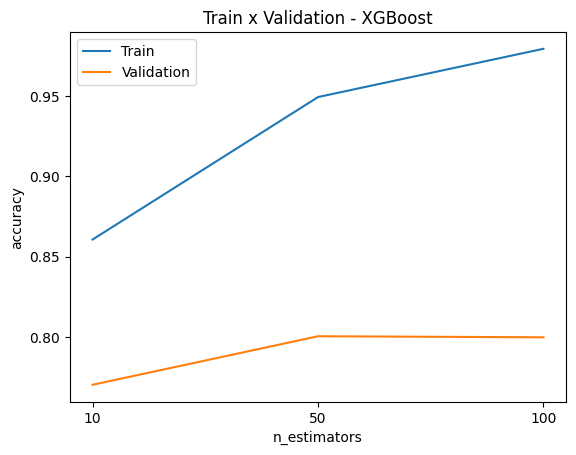

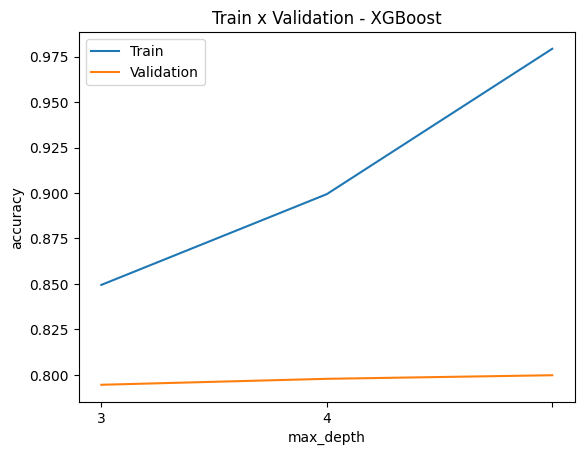

In [ ]:
plot_train_validation_graph("XGBoost", metrics, **xgb_hyper_params)

## SVM Params

- Parâmetros: gamma, C

In [ ]:
svm_template = {
    'kernel': 'rbf',
    'random_state': RANDOM_STATE
}

svm_hyper_params = {
    'gamma': [0.01, 0.05, 0.1],
    'C': [1.5, 5.0, 10.0]
}

metrics = get_model_metrics(SVC, X_train, y_train, X_test, y_test, svm_template, **svm_hyper_params)

- Plotagem

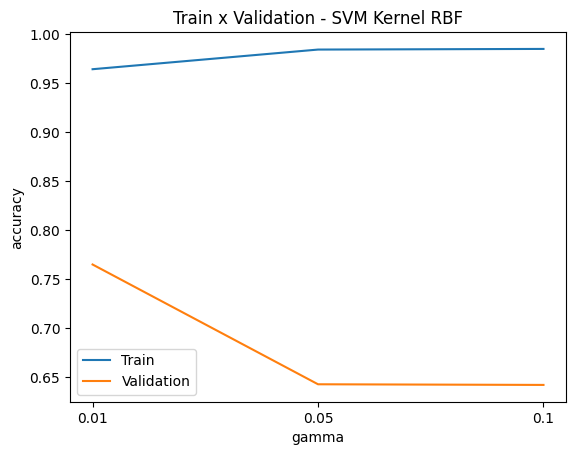

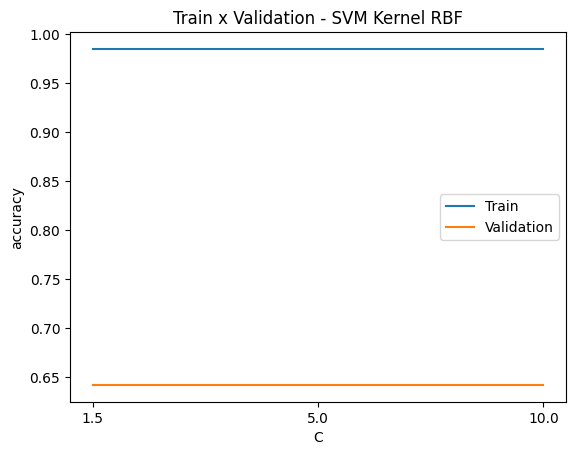

In [ ]:
plot_train_validation_graph("SVM Kernel RBF", metrics, **svm_hyper_params)

## Random Forest Params

- Parâmetros: n_estimators, max_depth, min_samples

In [ ]:
rd_forest_template = {
    "random_state": RANDOM_STATE
}

rd_forest_hyper_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [4, 8, None],
    'min_samples_split': [10, 50, 100]
}

metrics = get_model_metrics(RandomForestClassifier, X_train, y_train, X_test, y_test,
                                                      rd_forest_template, **rd_forest_hyper_params)

- Plotagem

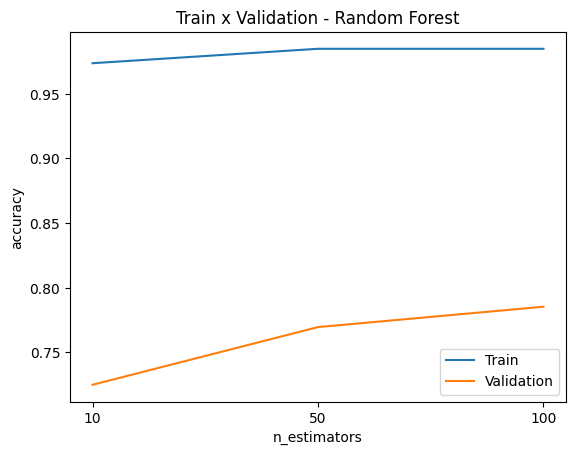

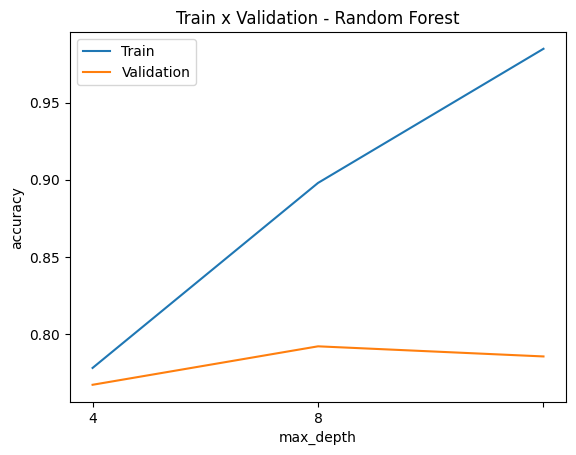

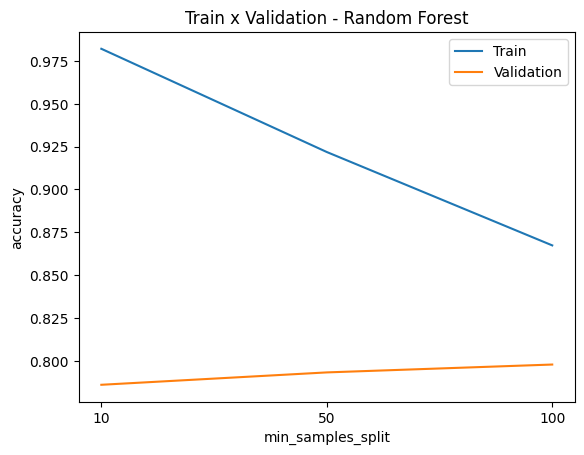

In [ ]:
plot_train_validation_graph("Random Forest", metrics, **rd_forest_hyper_params)

# XGBoost e escolha dos hiperparâmetros

- Escolha dos hiperparâmetros e definição do modelo

In [ ]:
xgb_n_estimators = 91
xgb_max_depth = None

xgb_model = XGBClassifier(
      n_estimators=xgb_n_estimators,
      learning_rate=0.1,
      max_depth=xgb_max_depth,
      objective='binary:logistic',
      eval_metric='logloss',
      random_state=RANDOM_STATE
)

#Inserção do modelo
stack_models['xgb'] = xgb_model


- Treinamento e avaliação do modelo

In [ ]:
xgb_model.fit(X_train, y_train)

#Predição
y_xgb_pred = xgb_model.predict(X_test)

#Avaliação
xgb_metrics = classification_report(y_test, y_xgb_pred)
print("XGBoost - Metrics")
print(xgb_metrics)

#Inserção do modelo treinado na lista de modelos selecinados
selected_models.append(xgb_model)

XGBoost - Metrics
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.72      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523



# SVM e escolha dos hiperparâmetros

- Escolha dos hiperparâmetros e definição do modelo

In [ ]:
gamma = 0.0006
C = 3.5

svm = SVC(
          kernel='rbf',
          gamma=gamma,
          C=C,
          random_state=RANDOM_STATE
      )

#Inserção do modelo
stack_models['svm'] = svm

- Treinamento e avaliação do modelo

In [ ]:
svm.fit(X_train, y_train)

#Predição
y_svm_pred = svm.predict(X_test)

#Avaliação
svm_metrics = classification_report(y_test, y_svm_pred)
print("SVM Kernel RBF - Metrics")
print(svm_metrics)

#Inserção do modelo treinado na lista de modelos selecinados
selected_models.append(svm)

SVM Kernel RBF - Metrics
              precision    recall  f1-score   support

           0       0.80      0.89      0.85       874
           1       0.83      0.71      0.76       649

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



# Random Forest e escolha dos hiperparâmetros

- Escolha dos hiperparâmetros e definição do modelo

In [ ]:
rd_forest_min_samples_split = 10
rd_forest_max_depth = None
rd_forest_n_estimators = 901

rd_forest = RandomForestClassifier(
    n_estimators=rd_forest_n_estimators,
    max_depth=rd_forest_max_depth,
    min_samples_split=rd_forest_min_samples_split,
    random_state=RANDOM_STATE
)

#Inserção do modelo
stack_models['RandomForest'] = rd_forest

- Treinamento e avaliação do modelo

In [ ]:
rd_forest.fit(X_train, y_train)

#Predição
y_rd_forest_pred = rd_forest.predict(X_test)

#Avaliação
rd_forest_metrics = classification_report(y_test, y_rd_forest_pred)
print("RandomForest - Metrics")
print(rd_forest_metrics)

#Inserção do modelo treinado na lista de modelos selecinados
selected_models.append(rd_forest)

RandomForest - Metrics
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



# Curvas ROC para cada modelo

- Criação das curvas ROC para os modelos com seus respectivos hiperparâmetros escolhidos

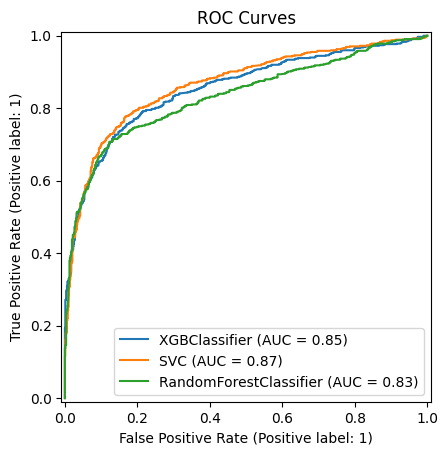

In [ ]:
xgb_ref = RocCurveDisplay.from_estimator(selected_models[0], X_test, y_test)

for model in selected_models[1:]:
   RocCurveDisplay.from_estimator(model, X_test, y_test, ax=xgb_ref.ax_)

plt.title("ROC Curves")
plt.show()

# Criação do Ensembler dos modelos para predição final

- Criação e treinamento do ensembler para classifiação final com base nos modelos com seus respectivos hiperparâmetros selecionados

In [ ]:
#cross-validation para definição do k-folds para treinamento dos modelos
k = 3

#Pega somente os 2 modelos com melhor curva ROC para compor o preditor final
models = ['xgb', 'svm']
estimators = [(model_name, stack_models[model_name]) for model_name in models]

#Criação do modelo preditor final
stack_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=k
)

#Treino
stack_classifier.fit(X_train, y_train)

#Predição
y_stack_pred = stack_classifier.predict(X_test)

- Métricas de avaliação

In [ ]:
#Métricas de avaliação
stack_matrics = classification_report(y_test, y_stack_pred)
print("Ensembler Classifier - Metrics")
print(stack_matrics)

Ensembler Classifier - Metrics
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       874
           1       0.81      0.75      0.78       649

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



# Teste de predição



- Leitura, tratamento dos dados e predição

In [ ]:
test_data = pd.read_csv('./datasets/test.csv')
test_texts = test_data['text']

#Limpeza dos dados
test_texts = pre_processing(test_texts)

#Vetorização
X_test_data = create_words_embedding(test_texts)

#Predição
y_pred_test = stack_classifier.predict(X_test_data)

- Inserção e salvamento dos dados classificados

In [ ]:
submission = pd.DataFrame()
submission['id'], submission['target'] = test_data['id'], y_pred_test

#Save file
submission.to_csv('sample_submission.csv', index=False)